In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_theme(style="whitegrid")
sns.color_palette("rocket", as_cmap=True)
sns.set_palette("pastel")
#hide all warnings
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(44)

In [2]:
reviews = pd.read_csv("reviews.csv")
reviews.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
reviews["game_name"]=reviews.game_name.str.split("       ",expand=True,)[0]
reviews.head()

,game_id,game_name,score,author,date,summary
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis..."
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...


In [4]:
stop_words=set(stopwords.words("english"))

#tokenised list of reviews that do not contain stop words
def tokenized_summary(x):
    filtered_sent=[]
    for w in word_tokenize(x):
        if w not in stop_words:
            filtered_sent.append(w)
    return filtered_sent

reviews["tokenised"] = reviews['summary'].apply(lambda x: tokenized_summary(x))

In [5]:
#Lemmatization 
import string
lem = WordNetLemmatizer()
def lemmatized_list(x):
    lemmatized=[]
    for w in x:
        lemmatized.append(lem.lemmatize(w))
    final_string =  " ".join(lemmatized)
    return final_string.translate(str.maketrans('', '', string.punctuation))


reviews["lemmatized"] = reviews['tokenised'].apply(lambda x: lemmatized_list(x))


In [6]:
reviews.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...


In [7]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

def vader_sentiment(x):
    sentiment_dict = sid_obj.polarity_scores(x)
    if sentiment_dict['compound'] > 0.05:
        return pd.Series(['positive', sentiment_dict['compound']])
    elif sentiment_dict['compound'] <= -0.05:
        return pd.Series(['negative', sentiment_dict['compound']])
    else:
        return pd.Series(['neutral',sentiment_dict['compound']])

reviews[["sentiment_label", 'sentiment_value']] = reviews['summary'].apply(lambda x: vader_sentiment(x))

In [8]:
reviews.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731


# User Search Recommendation Using Count Vectorizer to Identify Attribute/Word Similarity

In [9]:
# get user input
attributes=input("Attribute search: ")

Attribute search: beautiful game design


In [10]:
attributes=" ".join(list(attributes.split()))
attributes

'beautiful game design'

In [11]:
# modifying the structure of the attributes
tempDataFrame=pd.DataFrame({'Game_review':[attributes]})
tempDataFrame=tempDataFrame.transpose()

In [12]:
# combining the selected attributes with the lematized game reviews
description_list1=reviews['lemmatized']
frames = [tempDataFrame, description_list1]
result = pd.concat(frames)
result.columns = ['review']
result=result.reset_index()

In [13]:
result.head()

,index,review
0,Game_review,beautiful game design
1,0,Traversing mind character much plot case ’ try...
2,1,Disco Elysium – The Final Cut something rare ...
3,2,Enhanced fantastic fresh content Disco Elysiu...
4,3,A fully voiced cast new content comparable qua...


In [14]:
# applying count vectorizer to the game reviews column
vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english')
total_features_words = vec_words.fit_transform(result['review'])

In [15]:
# calculating similarity between game reviews using cosine similiarity
subset_sparse = sparse.csr_matrix(total_features_words)
total_features_review=subset_sparse
total_features_attr=subset_sparse[0,]
similarity=1-pairwise_distances(total_features_attr,total_features_review, metric='cosine')

In [16]:
# merging similarity values into the game reviews dataframe
similarity=pd.DataFrame(similarity)
similarity=similarity.transpose()
similarity.columns = ['similarity']
similarity=similarity.drop(similarity.index[[0]])
reviews_df=reviews.assign(similarity=similarity.values)

In [17]:
# filtering top 10 positive and similar game reviews
reviews_df=reviews_df.sort_values(by=["similarity"],ascending=False)
reviews_df_sim=reviews_df["sentiment_value"]>=0.8
reviews_df_pos_sim=reviews_df[reviews_df_sim]
reviews_df_pos_sim[["game_name","score","author","date","summary"]].head(10).sort_values(by="score", ascending=False)

,game_name,score,author,date,summary
515,Inscryption,100,Gaming Nexus,"Oct 18, 2021","Go into Inscryption as unspoiled as possible, ..."
323,Mini Motorways,90,IGN Japan,"Aug 30, 2021",Similar to Dinosaur Polo Club’s previous game ...
1761,Gloomhaven,90,Games.cz,"Nov 30, 2021",The best-reviewed board game in the world gets...
473,Death's Door,90,Digitally Downloaded,"Jul 20, 2021",Death’s Door is a tremendously well-designed g...
2553,Sable,90,But Why Tho?,"Sep 22, 2021",Playing Sable very well may be as close as one...
2555,Sable,90,Checkpoint Gaming,"Sep 22, 2021",The occasional bug and missing stamina upgrade...
745,Little Nightmares II,88,Atomix,"Feb 9, 2021",Little Nightmares 2 is a fantastic sequel that...
2815,The Wild At Heart,80,God is a Geek,"May 20, 2021","The WIld at Heart is a beautiful game, with so..."
2522,Jurassic World Evolution 2,60,Games.cz,"Jan 13, 2022",Building your own Dino Park may be more fun th...
3961,Mutropolis,60,Digital Chumps,"Feb 26, 2021","Overall, Metropolis has the bones to be a grea..."


# CLUSTERING

## Using Count Vectorizer with sum aggregation for clustering

In [18]:
# applying countvectorizer vectorizer to the lematized game reviews column
#vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english',min_df=10, max_features=500)
vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english',max_features=500)
vectors = vec_words.fit_transform(reviews['lemmatized'])

feature_names = vec_words.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
count = pd.DataFrame(denselist, columns=feature_names)

In [19]:
# looking at column names
column_names = count.columns
#list(column_names)

In [20]:
# joining the game reviews df with the count vectorized attributes
final_df = reviews.join(count)
final_df.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,worth,worthy,writing,year,–,—,‘,’,“,”
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960,...,0,0,0,0,0,0,0,3,0,0
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0,0,0,0,1,0,0,3,0,0
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0,0,0,0,0,0,0,1,0,0
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,0,0,0,1,0,0,0,0,0,0
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# only include relevant attributes for clustering
attributes = pd.read_csv("topic-grouping-v2.csv")
attributes=attributes[["word","Group"]]
attributes=attributes[attributes["Group"].str.contains("ignore")==False]
attributes

,word,Group
0,dark,tone
1,entertaining,tone
2,strategy,strategy based gameplay
3,mission,game design
4,easily,difficulty
...,...,...
162,life,narrative
164,pretty,visuals
166,gorgeous,visuals
168,time,playthrough time


In [22]:
# identifying list of columns to keep
tokeep=list(attributes["word"])
#tokeep

In [23]:
# identifying current list of columns
cols=list(final_df.columns)
#cols

In [24]:
contentstokeep=final_df.iloc[:,:10]

In [25]:
# removing the column names that aren't part of the list of columns to keep
final_df.iloc[:,10:]
for i in cols:
    if i not in tokeep:
        final_df.drop(columns=[i], inplace=True)

In [26]:
final_df=contentstokeep.join(final_df)
final_df

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,strategy,survival,tactical,technical,time,turnbased,visuals,vr,world,worth
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960,...,0,0,0,0,0,0,0,0,1,0
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0,0,0,0,0,0,0,0,0,0
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0,0,0,0,0,0,0,0,0,0
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,0,0,0,0,0,0,0,0,0,0
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,320,eFootball 2022,30,PC Gamer,"Oct 13, 2021","In PR terms, it's the world's costliest public...","[In, PR, terms, ,, 's, world, 's, costliest, p...",In PR term s world s costliest public beta T...,neutral,0.0000,...,0,0,0,0,0,0,0,0,1,0
5504,320,eFootball 2022,28,GameStar,"Oct 10, 2021",It's the worst-rated game on Steam for a reaso...,"[It, 's, worst-rated, game, Steam, reason, ,, ...",It s worstrated game Steam reason soccer fan ...,negative,-0.6486,...,0,0,0,0,0,0,0,0,0,0
5505,320,eFootball 2022,20,Gamer.no,"Oct 10, 2021","The game is straight up horrible, and I can’t ...","[The, game, straight, horrible, ,, I, ’, under...",The game straight horrible I ’ understand som...,neutral,-0.0258,...,0,0,0,0,0,0,0,0,0,0
5506,320,eFootball 2022,20,PC Games,"Oct 5, 2021",The Pro Evolution Soccer series was all the ti...,"[The, Pro, Evolution, Soccer, series, time, wo...",The Pro Evolution Soccer series time worthy op...,negative,-0.0644,...,0,0,0,0,1,0,0,0,0,0


In [27]:
final_df.columns # left with 86 columns

Index(['game_id', 'game_name', 'score', 'author', 'date', 'summary',
       'tokenised', 'lemmatized', 'sentiment_label', 'sentiment_value',
       'action', 'adventure', 'aesthetic', 'age', 'animation', 'artistic',
       'attention', 'battle', 'boring', 'campaign', 'challenging', 'chance',
       'character', 'classic', 'combat', 'complete', 'coop', 'dark',
       'decision', 'design', 'easily', 'effect', 'element', 'enjoy',
       'entertaining', 'entry', 'exciting', 'experience', 'exploration', 'fan',
       'fantasy', 'fascinating', 'fight', 'flaw', 'franchise', 'fun',
       'gameplay', 'genius', 'genre', 'gorgeous', 'hard', 'hero', 'hour',
       'interesting', 'intriguing', 'issue', 'jrpg', 'life', 'lost',
       'management', 'mechanic', 'mission', 'mode', 'multiplayer', 'music',
       'narrative', 'nice', 'openworld', 'pace', 'pc', 'play', 'pleasant',
       'polish', 'pretty', 'problem', 'puzzle', 'remaster', 'rough', 'run',
       'series', 'shooter', 'simulator', 'single'

In [28]:
# getting only the positive sentiment reviews for clustering
final_df_positive=final_df[final_df.sentiment_label=="positive"]
final_df_positive

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,strategy,survival,tactical,technical,time,turnbased,visuals,vr,world,worth
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0,0,0,0,0,0,0,0,0,0
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0,0,0,0,0,0,0,0,0,0
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,0,0,0,0,0,0,0,0,0,0
5,0,Disco Elysium: The Final Cut,100,Ragequit.gr,"Mar 30, 2021",The Final Cut update to Disco Elysium elevates...,"[The, Final, Cut, update, Disco, Elysium, elev...",The Final Cut update Disco Elysium elevates ma...,positive,0.8164,...,0,0,0,0,0,0,0,0,0,0
6,0,Disco Elysium: The Final Cut,100,IGN,"Mar 30, 2021",Disco Elysium is a unique blend of noir-detect...,"[Disco, Elysium, unique, blend, noir-detective...",Disco Elysium unique blend noirdetective ficti...,positive,0.8979,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,319,Balan Wonderworld,40,IGN,"Mar 30, 2021",Balan Wonderworld isn’t always an awful platfo...,"[Balan, Wonderworld, ’, always, awful, platfor...",Balan Wonderworld ’ always awful platformer c...,positive,0.6433,...,0,0,0,0,0,0,0,0,0,0
5496,319,Balan Wonderworld,30,Gfinity,"Apr 5, 2021",Balan Wonderworld gets no standing ovation for...,"[Balan, Wonderworld, gets, standing, ovation, ...",Balan Wonderworld get standing ovation – even ...,positive,0.5244,...,0,0,0,0,0,0,0,0,0,0
5497,319,Balan Wonderworld,30,GameSkinny,"Mar 30, 2021",Balan Wonderworld tries to be an homage to nos...,"[Balan, Wonderworld, tries, homage, nostalgic,...",Balan Wonderworld try homage nostalgic platfor...,positive,0.5927,...,0,0,0,0,0,0,0,0,0,0
5499,319,Balan Wonderworld,20,GamesBeat,"Apr 13, 2021","Balan Wonderworld is a $60 game, but I wouldn’...","[Balan, Wonderworld, $, 60, game, ,, I, ’, rec...",Balan Wonderworld 60 game I ’ recommend even...,positive,0.8952,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# creating 2 separate data frames for calculations

# df with just the attributes 
final_df2=final_df_positive.drop(columns=["game_name","author","date","summary","tokenised","lemmatized","sentiment_label","score","sentiment_value"])

# df with just the metascore and sentiment value
final_df3=final_df_positive[["game_id","score","sentiment_value"]]

In [30]:
# aggregate values of each attribute column by the sum for each video game
final_df4=final_df2.groupby("game_id").sum() 
final_df5=final_df3.groupby("game_id").mean() # getting the mean metascore and sentiment for each video game
final_df6 = final_df5.join(final_df4)
final_df6.head()

,score,sentiment_value,action,adventure,aesthetic,age,animation,artistic,attention,battle,...,strategy,survival,tactical,technical,time,turnbased,visuals,vr,world,worth
game_id,,,,,,,,,,,,,,,,,,,,,
0,96.666667,0.735444,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4,0
1,91.920000,0.853412,0,4,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,91.500000,0.903622,2,3,0,0,0,0,0,0,...,0,0,0,0,3,0,1,0,0,2
3,90.227273,0.808218,0,8,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,4,1
4,89.580645,0.829871,1,6,0,2,0,0,0,0,...,0,0,0,0,7,0,1,0,6,3


In [31]:
grps=list(attributes["Group"].unique())
final_df7=final_df6.iloc[:,:2]
cols=final_df6.columns[2:]
cols

Index(['action', 'adventure', 'aesthetic', 'age', 'animation', 'artistic',
       'attention', 'battle', 'boring', 'campaign', 'challenging', 'chance',
       'character', 'classic', 'combat', 'complete', 'coop', 'dark',
       'decision', 'design', 'easily', 'effect', 'element', 'enjoy',
       'entertaining', 'entry', 'exciting', 'experience', 'exploration', 'fan',
       'fantasy', 'fascinating', 'fight', 'flaw', 'franchise', 'fun',
       'gameplay', 'genius', 'genre', 'gorgeous', 'hard', 'hero', 'hour',
       'interesting', 'intriguing', 'issue', 'jrpg', 'life', 'lost',
       'management', 'mechanic', 'mission', 'mode', 'multiplayer', 'music',
       'narrative', 'nice', 'openworld', 'pace', 'pc', 'play', 'pleasant',
       'polish', 'pretty', 'problem', 'puzzle', 'remaster', 'rough', 'run',
       'series', 'shooter', 'simulator', 'single', 'sniper', 'space', 'story',
       'strategy', 'survival', 'tactical', 'technical', 'time', 'turnbased',
       'visuals', 'vr', 'world', '

In [32]:
# merging the counts for each word by the identified groups
for i in grps:
    df=attributes[attributes["Group"]==i]
    # cols = columns in the current dataframe
    final_df6[i]=0
    for j in cols:
        if j in list(df["word"]):
            final_df6[i]=final_df6[i]+final_df6[j]

In [33]:
final_df7=final_df7.join(final_df6.iloc[:,-13:])

In [34]:
final_df7

,score,sentiment_value,tone,strategy based gameplay,game design,difficulty,skill based gameplay,enjoyment,luck based gameplay,world building,technical performance,innovative,playthrough time,value,sound track
game_id,,,,,,,,,,,,,,,
0,96.666667,0.735444,0,0,9,0,0,0,0,4,1,1,1,0,0
1,91.920000,0.853412,0,0,16,0,1,7,0,19,1,5,1,0,1
2,91.500000,0.903622,0,0,9,0,2,9,0,2,3,9,5,2,0
3,90.227273,0.808218,0,8,19,1,0,9,0,6,5,0,4,1,0
4,89.580645,0.829871,4,1,19,0,4,15,0,7,6,6,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,51.857143,0.523514,1,0,6,0,1,1,0,0,1,2,3,0,0
317,49.666667,0.310933,0,0,2,0,0,1,0,0,0,0,0,1,0
318,48.000000,0.650590,2,0,9,0,0,7,0,0,1,1,1,1,5


In [35]:
# applying cosine similiarty
from sklearn.metrics.pairwise import cosine_similarity
dist=1-cosine_similarity(final_df7)
dist

array([[ 2.22044605e-16,  1.94282648e-02,  1.03254583e-02, ...,
         2.13409807e-02,  1.62144389e-02,  5.38127400e-03],
       [ 1.94282648e-02, -2.22044605e-16,  2.12144607e-02, ...,
         2.78951409e-02,  2.91161733e-02,  3.88022984e-02],
       [ 1.03254583e-02,  2.12144607e-02,  1.11022302e-16, ...,
         1.46016197e-02,  1.13009294e-02,  1.68714193e-02],
       ...,
       [ 2.13409807e-02,  2.78951409e-02,  1.46016197e-02, ...,
         2.22044605e-16,  1.56580925e-02,  3.36132915e-02],
       [ 1.62144389e-02,  2.91161733e-02,  1.13009294e-02, ...,
         1.56580925e-02,  3.33066907e-16,  1.64932875e-02],
       [ 5.38127400e-03,  3.88022984e-02,  1.68714193e-02, ...,
         3.36132915e-02,  1.64932875e-02,  0.00000000e+00]])

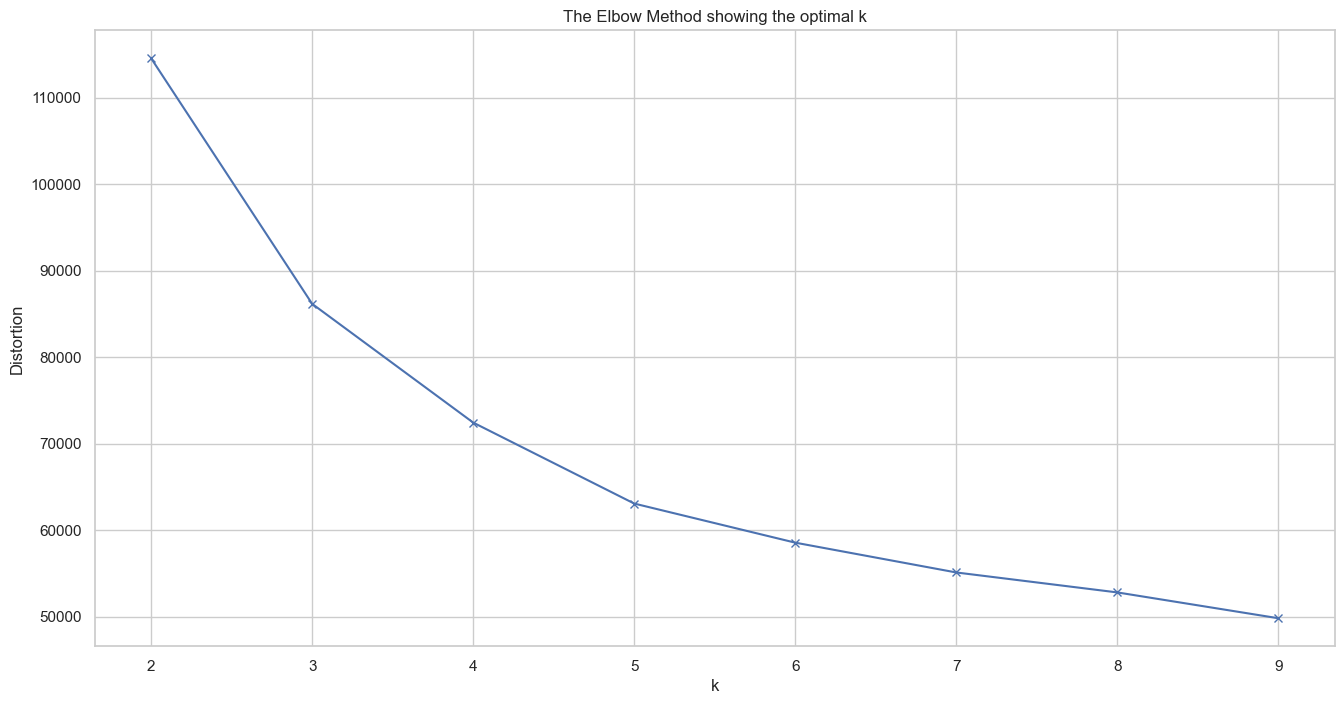

In [36]:
# using elbow method to determine number of clusters 
from sklearn.cluster import KMeans
vals = []
for i in range(2,10):
    kmeans=KMeans(n_clusters=i)
    model = kmeans.fit(final_df7)
    vals.append(model.inertia_)
K=range(2,10)
plt.figure(figsize=(16,8))
plt.plot(K, vals, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [37]:
# k-means clustering with 3 clusters
from sklearn.cluster import KMeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(final_df7)
clusters = km.labels_.tolist()

In [38]:
import joblib
joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [39]:
# creating dataframe for clusters
dictionary={"clusters":clusters}
clusts=pd.DataFrame(dictionary)
clusts.head()

,clusters
0,1
1,1
2,1
3,1
4,0


In [40]:
# joining the clusters to the grouped file
games=final_df7.join(clusts)
games

,score,sentiment_value,tone,strategy based gameplay,game design,difficulty,skill based gameplay,enjoyment,luck based gameplay,world building,technical performance,innovative,playthrough time,value,sound track,clusters
game_id,,,,,,,,,,,,,,,,
0,96.666667,0.735444,0,0,9,0,0,0,0,4,1,1,1,0,0,1
1,91.920000,0.853412,0,0,16,0,1,7,0,19,1,5,1,0,1,1
2,91.500000,0.903622,0,0,9,0,2,9,0,2,3,9,5,2,0,1
3,90.227273,0.808218,0,8,19,1,0,9,0,6,5,0,4,1,0,1
4,89.580645,0.829871,4,1,19,0,4,15,0,7,6,6,8,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,51.857143,0.523514,1,0,6,0,1,1,0,0,1,2,3,0,0,1
317,49.666667,0.310933,0,0,2,0,0,1,0,0,0,0,0,1,0,1
318,48.000000,0.650590,2,0,9,0,0,7,0,0,1,1,1,1,5,1


In [41]:
gamenames=pd.DataFrame(final_df.game_name.unique())
gamenames

,0
0,Disco Elysium: The Final Cut
1,Final Fantasy XIV: Endwalker
2,Forza Horizon 5
3,Chicory: A Colorful Tale
4,Psychonauts 2
...,...
316,Demon Skin
317,Arkham Horror: Mother's Embrace
318,Of Bird and Cage
319,Balan Wonderworld


In [42]:
games2=games.join(gamenames)

In [43]:
games2.to_csv("clusters.csv") # outputting cluster results with each video game to csv

In [44]:
# seeing how many games are in each cluster
games["clusters"].value_counts()

1    267
0     53
2      1
Name: clusters, dtype: int64

In [45]:
# average metascore per cluster
grouped=games["score"].groupby(games["clusters"])

grouped.mean()

clusters
0    78.940786
1    74.325868
2    82.706667
Name: score, dtype: float64

In [46]:
# average sentiment per cluster
grouped=games["sentiment_value"].groupby(games["clusters"])

grouped.mean()

clusters
0    0.746553
1    0.732928
2    0.758612
Name: sentiment_value, dtype: float64

In [47]:
# selecting only the attributes columns
attributes2=final_df7.iloc[:,2:]
attributes2.columns.tolist()

['tone',
 'strategy based gameplay',
 'game design',
 'difficulty',
 'skill based gameplay',
 'enjoyment',
 'luck based gameplay',
 'world building',
 'technical performance',
 'innovative',
 'playthrough time',
 'value',
 'sound track']

In [48]:
# identifying the closest attributes to each cluster centroid
# code taken from : https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :11]:
        print(' %s' % attributes2.columns.tolist()[ind], end='')
        print()

Top terms per cluster:
Cluster 0:
 tone
 skill based gameplay
 world building
 sound track
 luck based gameplay
 innovative
 value
 playthrough time
 difficulty
 game design
 enjoyment
Cluster 1:
 tone
 skill based gameplay
 world building
 sound track
 innovative
 value
 luck based gameplay
 playthrough time
 difficulty
 game design
 enjoyment
Cluster 2:
 value
 tone
 skill based gameplay
 world building
 difficulty
 playthrough time
 sound track
 game design
 innovative
 enjoyment
 luck based gameplay


In [49]:
gamenames=list(final_df.game_name.unique())

In [50]:
# converting numpy array of similarity into dataframe
dist2=pd.DataFrame(dist)
dist2=dist2.set_axis([gamenames], axis=1)
dist2=dist2.set_axis([gamenames], axis="index")
dist2

,Disco Elysium: The Final Cut,Final Fantasy XIV: Endwalker,Forza Horizon 5,Chicory: A Colorful Tale,Psychonauts 2,Streets of Rage 4: Mr. X Nightmare,It Takes Two,Hitman 3,Wildermyth,Final Fantasy VII Remake Intergrade,...,Foreclosed,Buildings Have Feelings Too!,Dungeons & Dragons: Dark Alliance,AWAY: The Survival Series,Grand Theft Auto: The Trilogy - The Definitive Edition,Demon Skin,Arkham Horror: Mother's Embrace,Of Bird and Cage,Balan Wonderworld,eFootball 2022
Disco Elysium: The Final Cut,2.220446e-16,1.942826e-02,1.032546e-02,0.016757,2.819167e-02,0.023360,0.021609,0.156162,0.010215,0.025298,...,0.009401,0.002279,0.150559,0.013188,0.005888,3.180344e-03,2.791736e-03,2.134098e-02,1.621444e-02,0.005381
Final Fantasy XIV: Endwalker,1.942826e-02,-2.220446e-16,2.121446e-02,0.016677,1.840069e-02,0.031353,0.022385,0.097315,0.018513,0.020318,...,0.025679,0.026191,0.138165,0.026194,0.025578,2.452124e-02,3.171978e-02,2.789514e-02,2.911617e-02,0.038802
Forza Horizon 5,1.032546e-02,2.121446e-02,1.110223e-16,0.015729,1.216037e-02,0.020943,0.015533,0.121946,0.007627,0.021758,...,0.009108,0.011086,0.123765,0.011160,0.008959,5.647687e-03,1.175740e-02,1.460162e-02,1.130093e-02,0.016871
Chicory: A Colorful Tale,1.675714e-02,1.667731e-02,1.572926e-02,0.000000,1.002372e-02,0.013352,0.005720,0.100565,0.008593,0.019074,...,0.013519,0.015063,0.127184,0.015121,0.024105,1.486130e-02,2.494278e-02,1.397558e-02,2.211372e-02,0.034156
Psychonauts 2,2.819167e-02,1.840069e-02,1.216037e-02,0.010024,1.110223e-16,0.017809,0.008351,0.076507,0.013574,0.018000,...,0.015617,0.028324,0.089897,0.019701,0.032341,1.999706e-02,3.628445e-02,1.338262e-02,2.288754e-02,0.047154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demon Skin,3.180344e-03,2.452124e-02,5.647687e-03,0.014861,1.999706e-02,0.017662,0.017080,0.138441,0.006698,0.024507,...,0.004532,0.003221,0.129577,0.009866,0.009232,-2.220446e-16,5.927472e-03,1.645909e-02,1.673580e-02,0.009756
Arkham Horror: Mother's Embrace,2.791736e-03,3.171978e-02,1.175740e-02,0.024943,3.628445e-02,0.030083,0.027583,0.185730,0.015090,0.035305,...,0.012153,0.004129,0.154613,0.018878,0.003679,5.927472e-03,-2.220446e-16,2.426781e-02,1.232523e-02,0.001305
Of Bird and Cage,2.134098e-02,2.789514e-02,1.460162e-02,0.013976,1.338262e-02,0.016115,0.007868,0.113247,0.018209,0.033669,...,0.017694,0.022803,0.107711,0.020800,0.025249,1.645909e-02,2.426781e-02,2.220446e-16,1.565809e-02,0.033613
Balan Wonderworld,1.621444e-02,2.911617e-02,1.130093e-02,0.022114,2.288754e-02,0.029753,0.017386,0.163976,0.019378,0.035455,...,0.017755,0.018140,0.118897,0.027199,0.008901,1.673580e-02,1.232523e-02,1.565809e-02,3.330669e-16,0.016493


In [51]:
# MDS plot for similarity
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist2) 
xs,ys = pos.T

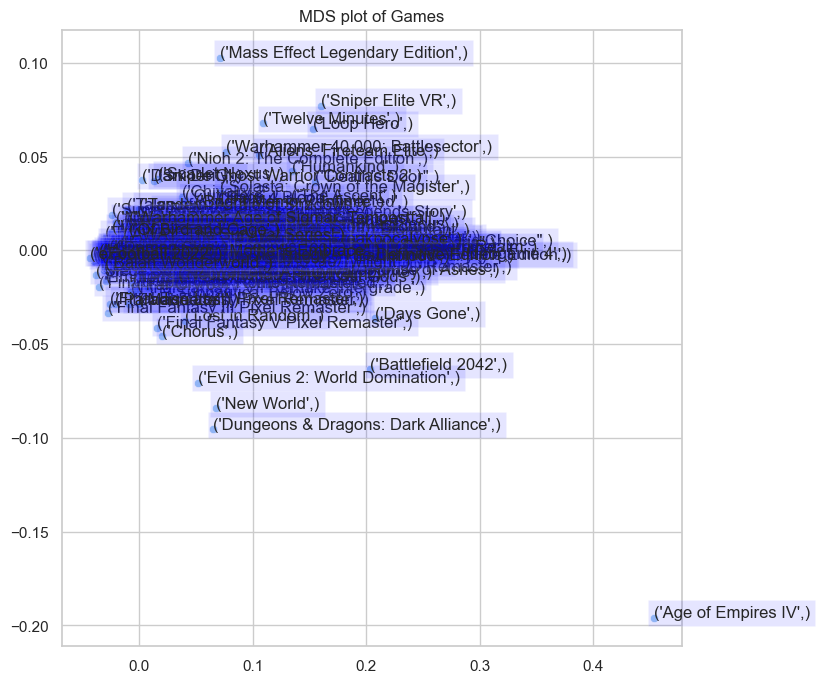

In [52]:
sns.scatterplot(xs,ys)
for i,game in enumerate(dist2.columns.values):
    plt.text(s=game, x= xs[i] , y=ys[i], bbox=dict(facecolor="blue",alpha=0.1))
plt.title('MDS plot of Games')
plt.savefig('MDSplot.png')
plt.show()

In [63]:
#set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:"#1e25a6"}
cluster_colors = {0: '#1e25a6', 1: '#66a61e', 2: '#d95f02'}

#set up cluster names using a dict
cluster_names = {0: 'Luck based gameplay', 
                 1: 'Innovative', 
                 2: 'Value'
                }

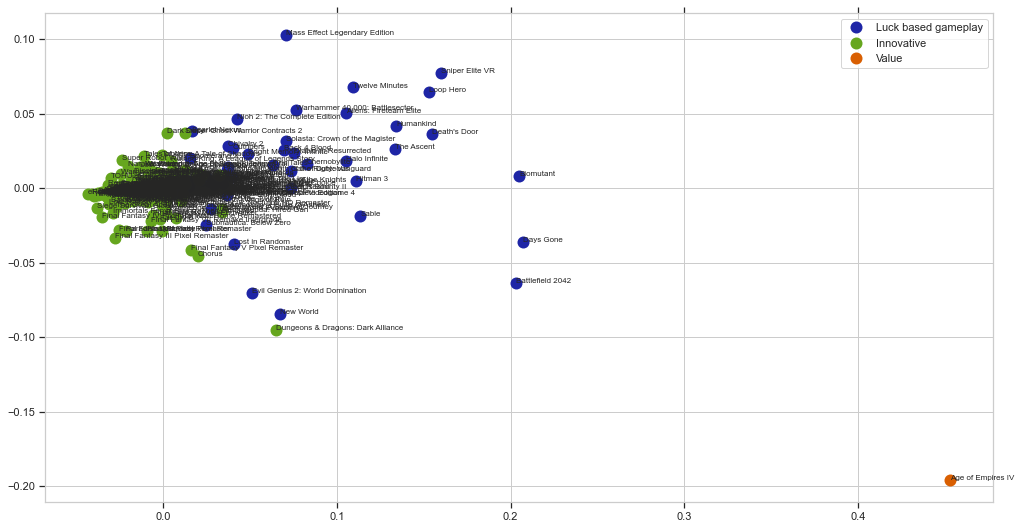

In [65]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=gamenames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
#fig, ax = plt.subplots(figsize=(100, 50)) # set size
ax.margins(0.05) 

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the game title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
plt.savefig('clusters_graph_games.png')    
plt.show() #show the plot


